# A study on the timeseries forecasting method: ARIMA


In [1]:
# initial imports
import pandas as pd

from TSErrors import FindErrors

import plotly.express as px
import plotly.graph_objects as go

import holidays

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX


## Data Preparation

The daily data (for confirmed cases in each) has already been preprocessed in [update_data.py](https://github.com/majimearun/crux-round3-tasks/blob/main/update_data.py) and is stored the data directory

Now we write a function that takes this cumulative time series and returns a new time series with number of new daily cases for a singular country, for:

1. Easier trend, seasonality identification
2. Reduce chances for the cumulative number to go down

In [2]:
confirmed_global = pd.read_csv(r"./data/country_confirmed.csv")

In [3]:
def get_data(country, confirmed=confirmed_global):
    confirmed = confirmed.groupby("country").sum().T
    confirmed.index = pd.to_datetime(confirmed.index, infer_datetime_format=True)
    data = pd.DataFrame(
            index=confirmed.index, data=confirmed[country].values, columns=["Total"]
        )
    # we remove the beginninhg 0s as they do not contribute
    data = data[(data != 0).all(1)]

    data_diff = data.diff()

    # removing the first value from data_diff 
    # it had no previous value and is a NaN after taking the difference
    data_diff = data_diff[1:]

    return data, data_diff

For the sake of this study we will be using the time series for India to build our model, but in the process we will also write generic functions and a workflow that can be used for any of the countries in the main dataset, with near optimal parameters.

In [4]:
country = "India"
confirmed_dfs = get_data(country)
confirmed_daily = confirmed_dfs[1] # taking the daily data, not the cumulative

In [5]:
confirmed_daily.tail(10)

,Total
2022-02-27,8013.0
2022-02-28,6915.0
2022-03-01,7554.0
2022-03-02,6561.0
2022-03-03,6396.0
2022-03-04,5921.0
2022-03-05,5476.0
2022-03-06,4362.0
2022-03-07,3993.0
2022-03-08,4575.0


In [6]:
# plotting our daily cases
px.line(confirmed_daily, title=f"Daily Confirmed Cases in {country}", template="plotly_dark")

We will be using holidays of that particular country as an additional feature (besides the past data), for the model to identify patterns.

In [7]:
holiday = [1 if i==True else 0 for i in [day in holidays.India() for day in confirmed_daily.index]]
confirmed_daily["holiday"] = holiday

In [8]:
df = confirmed_daily.copy()
df = df[["holiday", "Total"]]
df[df["holiday"] == 1].tail() # making sure there are holidays in the data that we are using

,holiday,Total
2021-10-02,1,22842.0
2021-11-04,1,12729.0
2021-12-25,1,6987.0
2022-01-14,1,268833.0
2022-01-26,1,286384.0


## Model Identification

Depending on the type of our time series, there are 2 to 7 parameters that we will need to identify:

1. **Stationary time series:**

A staionary time series is a time series whose value(and covariance) does not depend on time at which the series is observed rather just the lag ***'k'*** wrt to some other point in the series, i.e one that has a constant mean and variance (and thus by default cannot have a non zero trend). An example of a perfectly stationary time series is a sine wave. But as time series are rarely perfectly stationary, we will set a threshold(p-value of 0.05 in adfuller) and use a test (Augmented Dicky-Fuller or adfuller) to identify if the time series is stationary or not.

Forecast of a stationary time series can be found using an ARMA model. It consists of two parts Autoreggressive(AR) and Moving Average(MA). Moving average is a technique that forecasts the future value of a time series data using the average (or of needed weighted average) of the past *n* values. The AR part is a regression on the time series itself measures/observed at different points with respect to a specified lag *k*. For example if we were use a AR model with lag 1 or AR(1), the model's equation would be given as follows:

***Y(t+1) = μ  + βY(t) + ε(t+1)***

where μ is the mean of the time series, β is the coefficient of the previous value of the time series, and ε(t+1) is the extra residual term

In this model, we need to identify only 2 parameters/orders: **p** and **q**, the lags for the AR and MA processes respectively. The final model will be a ARMA(p,q) or ARIMA(p,0,q)

2. **Non stationary and non seasonal:**

If our time series does not satisfy the conditions for the stationary time series, we will use the method of differencing to convert our time series to a stationary time series. This is what the extra ***'I'*** in ARIMA stands for: Integration, i.e, order of differencing.

In this model, the 3 parameters/orders we will need to identify are: **p**, **q** (same as that from ARMA) and **d**, the order of differencing. The final model will be ARIMA(p,d,q).

3. **Seasonal time series:**

If our time series has an additional seasonality component, we will need to use SARIMA/SARIMAX model to forecast (Seasonal ARIMA) for the forecast, as seasonality doesnt work well with the standard ARIMA model. For this, in addition to the 3 parameters we found in ARIMA, we will need to identify:

1. ***P*** and ***Q***: the lags of the **seasonal component** of the time series
2. ***D***: the order of differencing for the seasonal component
3. ***s or m***: the number of seasonal periods in the time series. (i.e, if m is 12, each period will be 1/4 of a year, so quarterly. If 12, then monthly etc.)


### Step 1

Checking if our time series is stationary or not, and if not, identify the order of differencing.

In [9]:
result=adfuller(df['Total'].dropna())
print(f'p-value: {result[1]}')

p-value: 0.08124784990657441


As our p-value is > 0.05, the time series is not stationary. 

Another show of this, is that the decrease/decline in the auto correlations is very slow (shown below)

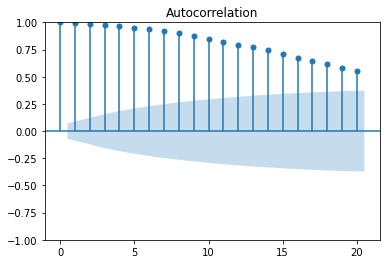

In [10]:
acf = plot_acf(df['Total'].dropna(), lags=20)

We will now try the same with the same series after a single difference (d = 1)

In [11]:
result=adfuller(df['Total'].diff().dropna())
print(f'p-value: {result[1]}')

p-value: 6.778172436582615e-09


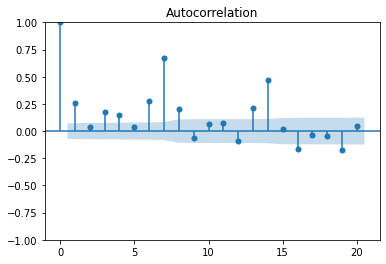

In [12]:
acf = plot_acf(df['Total'].diff().dropna(), lags=20)

After this single difference, we find that our time series satisfies both conditions for being stationary.

We have successfully identified the order of differencing to be 1. (i.e, **d = 1**) 

### Step 2:

To identify the lags **p** and **q** manually, we can follow the steps:

1. The partial autocorrelation is significant only for the first p-values/lags and cuts off to zero.
2. The autocorrelation values is significant only for the first q-values/lags and cuts off to zero.

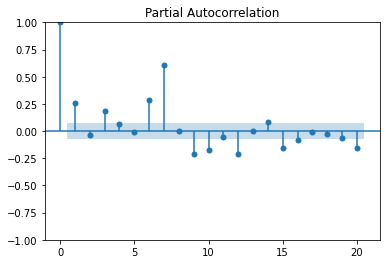

In [13]:
# manually identifying p

pacf = plot_pacf(df['Total'].diff().dropna(), lags=20)

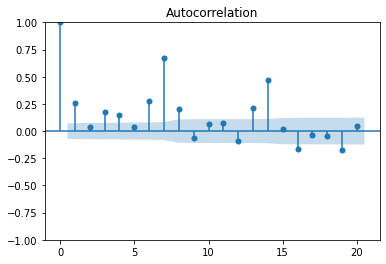

In [14]:
# manually identifying q

acf = plot_acf(df['Total'].diff().dropna(), lags=20)

From these plots we can see the lags upto 2 for both acf and pacf are significant, therfore our manual arrived values of p and q are 2 and 2 respectively.

So the model we arrived at from our analysis is ARIMA(2,1,2) (NOTE: we do not need to and so haven't yet checked or accounted for the seasonal component)

## Model Evaluation

In [15]:
df.index.freq = "D"
arima = SARIMAX(df['Total'], order=(2,1,2), exog=df['holiday'])
model = arima.fit(method="powell")

Optimization terminated successfully.
         Current function value: 10.392263
         Iterations: 2
         Function evaluations: 145


In [16]:
# we now evaluate our model
pred = model.predict(start=len(df['Total'])-28, end=len(df['Total'])-1, exog=df["holiday"][-28:],dynamic=False)

In [17]:
errors = FindErrors(df[-28:]["Total"], pred)
print(f"MAPE: {errors.mape()}") # mean absolute pecentage error
print(f"RMSE: {errors.rmse()}") # root mean square error

MAPE: 9.505075716252787
RMSE: 2344.112358582104


In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[-28:].index, y=df[-28:]['Total'], name="Actual"))
fig.add_trace(go.Scatter(x=df[-28:].index, y=pred, name="Predicted"))
fig.update_layout(title_text=f"{country} Confirmed Cases", xaxis_title="Date", yaxis_title="Cases", template="plotly_dark", hovermode="x")

Additionally, to both comapre with out analysis and to optimize our model, we can use auto_arima from pmdarima, which works like a grid search for the most optimal parameters

In [19]:
results=pm.auto_arima(df['Total'], start_p=1, d=1, start_q=1, max_p=2, max_q=2,
                    information_criterion='bic', trace=True, error_action='ignore',
                    exog=df['holiday'], stepwise=True, freq="D")

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=16046.629, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=16090.383, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=16045.608, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=16041.155, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=16083.742, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=16047.334, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=16018.463, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=16001.637, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=16040.849, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[0]             : BIC=15994.993, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=16011.814, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0]             : BIC=16034.207, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=16039.987, Time=0.11 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 2.843 seconds


This agrees with our analysis!!

NOTES:

1. Setting a higher max_p and max_q might result in auto_arima resulting in a different model, but by experimenting with those values, I observed that the model was getting overfitted , and hence stuck to theor max values being 2 and 2 respectively.

2. We do not take into account seasonality here as ARIMA/SARIMAX is known to face many problems in high frequency data (even weekly data *(m=52)* causes problems, and ours is daily data *(m=365)*) and in data where the seasonal cycles are too long, as mentioned in these links:

[a. Poor perfomance on long cycles](https://stats.stackexchange.com/questions/406718/getting-best-fitted-model-using-auto-arima-but-prediction-result-is-very-bad), 

[b. SARIMAX too blunt for high frequncy data](https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax)(Answer written by one of the authors of statsmodels himself!!)

## Forecasting

In [20]:
datelist = pd.date_range(start=df.index[-1], periods= 8, freq="D")[1:]

In [21]:
is_holiday = [1 if i==True else 0 for i in [day in holidays.India() for day in datelist]]

In [22]:
forecast = model.get_forecast(steps=7, exog = is_holiday)
mean_forecast=forecast.predicted_mean

In [23]:
print(mean_forecast)

2022-03-09    4141.817853
2022-03-10    3606.371074
2022-03-11    3169.288497
2022-03-12    2717.287363
2022-03-13    2310.931332
2022-03-14    1914.688607
2022-03-15    1546.317152
Freq: D, Name: predicted_mean, dtype: float64


In [24]:
# converting to cumulative form for final plot and prediction format
start = confirmed_dfs[0]["Total"][-1]
predictions_cumulative = []
for i in mean_forecast :
    start = start + i
    predictions_cumulative.append(start)

In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=confirmed_dfs[0].index[-60:], y=confirmed_dfs[0]["Total"][-60:],   
                        mode='lines',
                        name='Up till now'))
    
fig.add_trace(go.Scatter(x=datelist, y=predictions_cumulative, 
                        mode='lines',
                        name='Prediction*'))

fig.update_layout(title_text=f"{country} Confirmed Cases", xaxis_title="Date", yaxis_title="Cases", template="plotly_dark", hovermode="x")

In [26]:
# function to format the number for easy readability
def format_number(number):
    s, *d = str(number).partition(".")
    r = ",".join([s[x-3:x] for x in range(-3, -len(s), -3)][::-1] + [s[-3:]])
    return "".join([r] + d)

In [27]:
predictions = pd.DataFrame()
predictions.index = datelist
predictions["Total"] = [format_number(str(int(i))) for i in predictions_cumulative]

In [28]:
predictions

,Total
2022-03-09,"42,980,024"
2022-03-10,"42,983,631"
2022-03-11,"42,986,800"
2022-03-12,"42,989,517"
2022-03-13,"42,991,828"
2022-03-14,"42,993,743"
2022-03-15,"42,995,289"
